In [194]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from timm.scheduler import CosineLRScheduler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")
import json
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes
import gc
import os
import torch.jit as jit
import torch.autograd as autograd
import random
from typing import List, Tuple#, Tensor

In [195]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
use_cuda

True

In [196]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
1
0
NVIDIA GeForce GTX 1650


In [197]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [198]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [199]:
# if torch.cuda.is_available():
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

In [200]:
df_train = pd.read_csv("../ML2024/archive/LSTM-Multivariate_pollution.csv")
df_train

date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1         0     0  
2         0     0  
3         1     0  
4         2     0  
...     ...   ...  
43795     0     0  
43796     0     0  
43797     0     0  
43798     0     0  
43799     0     0  

[43800 rows x 9 columns]

In [201]:
df_train = df_train.drop(columns = ["date"])

In [202]:
df_test = pd.read_csv("../ML2024/archive/pollution_test_data1.csv")
df_test

dew  temp  press wnd_dir  wnd_spd  snow  rain  pollution
0    -16     4   1027      SE     3.58     0     0        128
1    -17     5   1027      SE     7.60     0     0         77
2    -16     4   1027      SE     9.39     0     0         65
3    -16     1   1028      cv     0.89     0     0         79
4    -14     0   1028      NE     1.79     0     0         93
..   ...   ...    ...     ...      ...   ...   ...        ...
341  -23    -2   1034      NW   231.97     0     0          8
342  -22    -3   1034      NW   237.78     0     0         10
343  -22    -3   1034      NW   242.70     0     0         10
344  -22    -4   1034      NW   246.72     0     0          8
345  -21    -3   1034      NW   249.85     0     0         12

[346 rows x 8 columns]

In [203]:
def cleaning(data: pd.DataFrame)->pd.DataFrame:
    print("before cleaning data")
    print(data.isna().sum())
    print("len of data is: ",len(data))

    print("after cleaning data")
    data.dropna()
    print(data.isna().sum())
    print("len of data is: ",len(data))
    return data
df_train = cleaning(df_train)

before cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800
after cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800


In [204]:
def view_data(data:pd.DataFrame)->None:
    #set subploannotationst parameters
    n_col = 2
    columns =  data.columns.tolist()

    #Create a subplot for each variable
    fig = make_subplots(rows =len(columns)//2,cols = n_col, subplot_titles = columns)
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']

    #counter for plot figure
    counts = 0

    #plot figures
    for col_color in zip (columns, colors):
        row = (counts >> 1) +1
        col = (counts & 1) +1
        fig.add_trace(go.Histogram(x=data[col_color[0]], nbinsx=20, marker_color=col_color[1]), row=row, col=col)

        #set x and y title
        fig.update_xaxes(title_text = 'value', row = row, col = col)
        fig.update_yaxes(title_text = 'Frequency', row = row, col = col)

        counts +=1
    #update layout and set set subplot title size
    fig.update_layout(height=1000, width=1200, title_text='Distribution of Variables', showlegend=False)
    fig.update_annotations(font_size=16)

    fig.show()
    return

view_data(df_train)

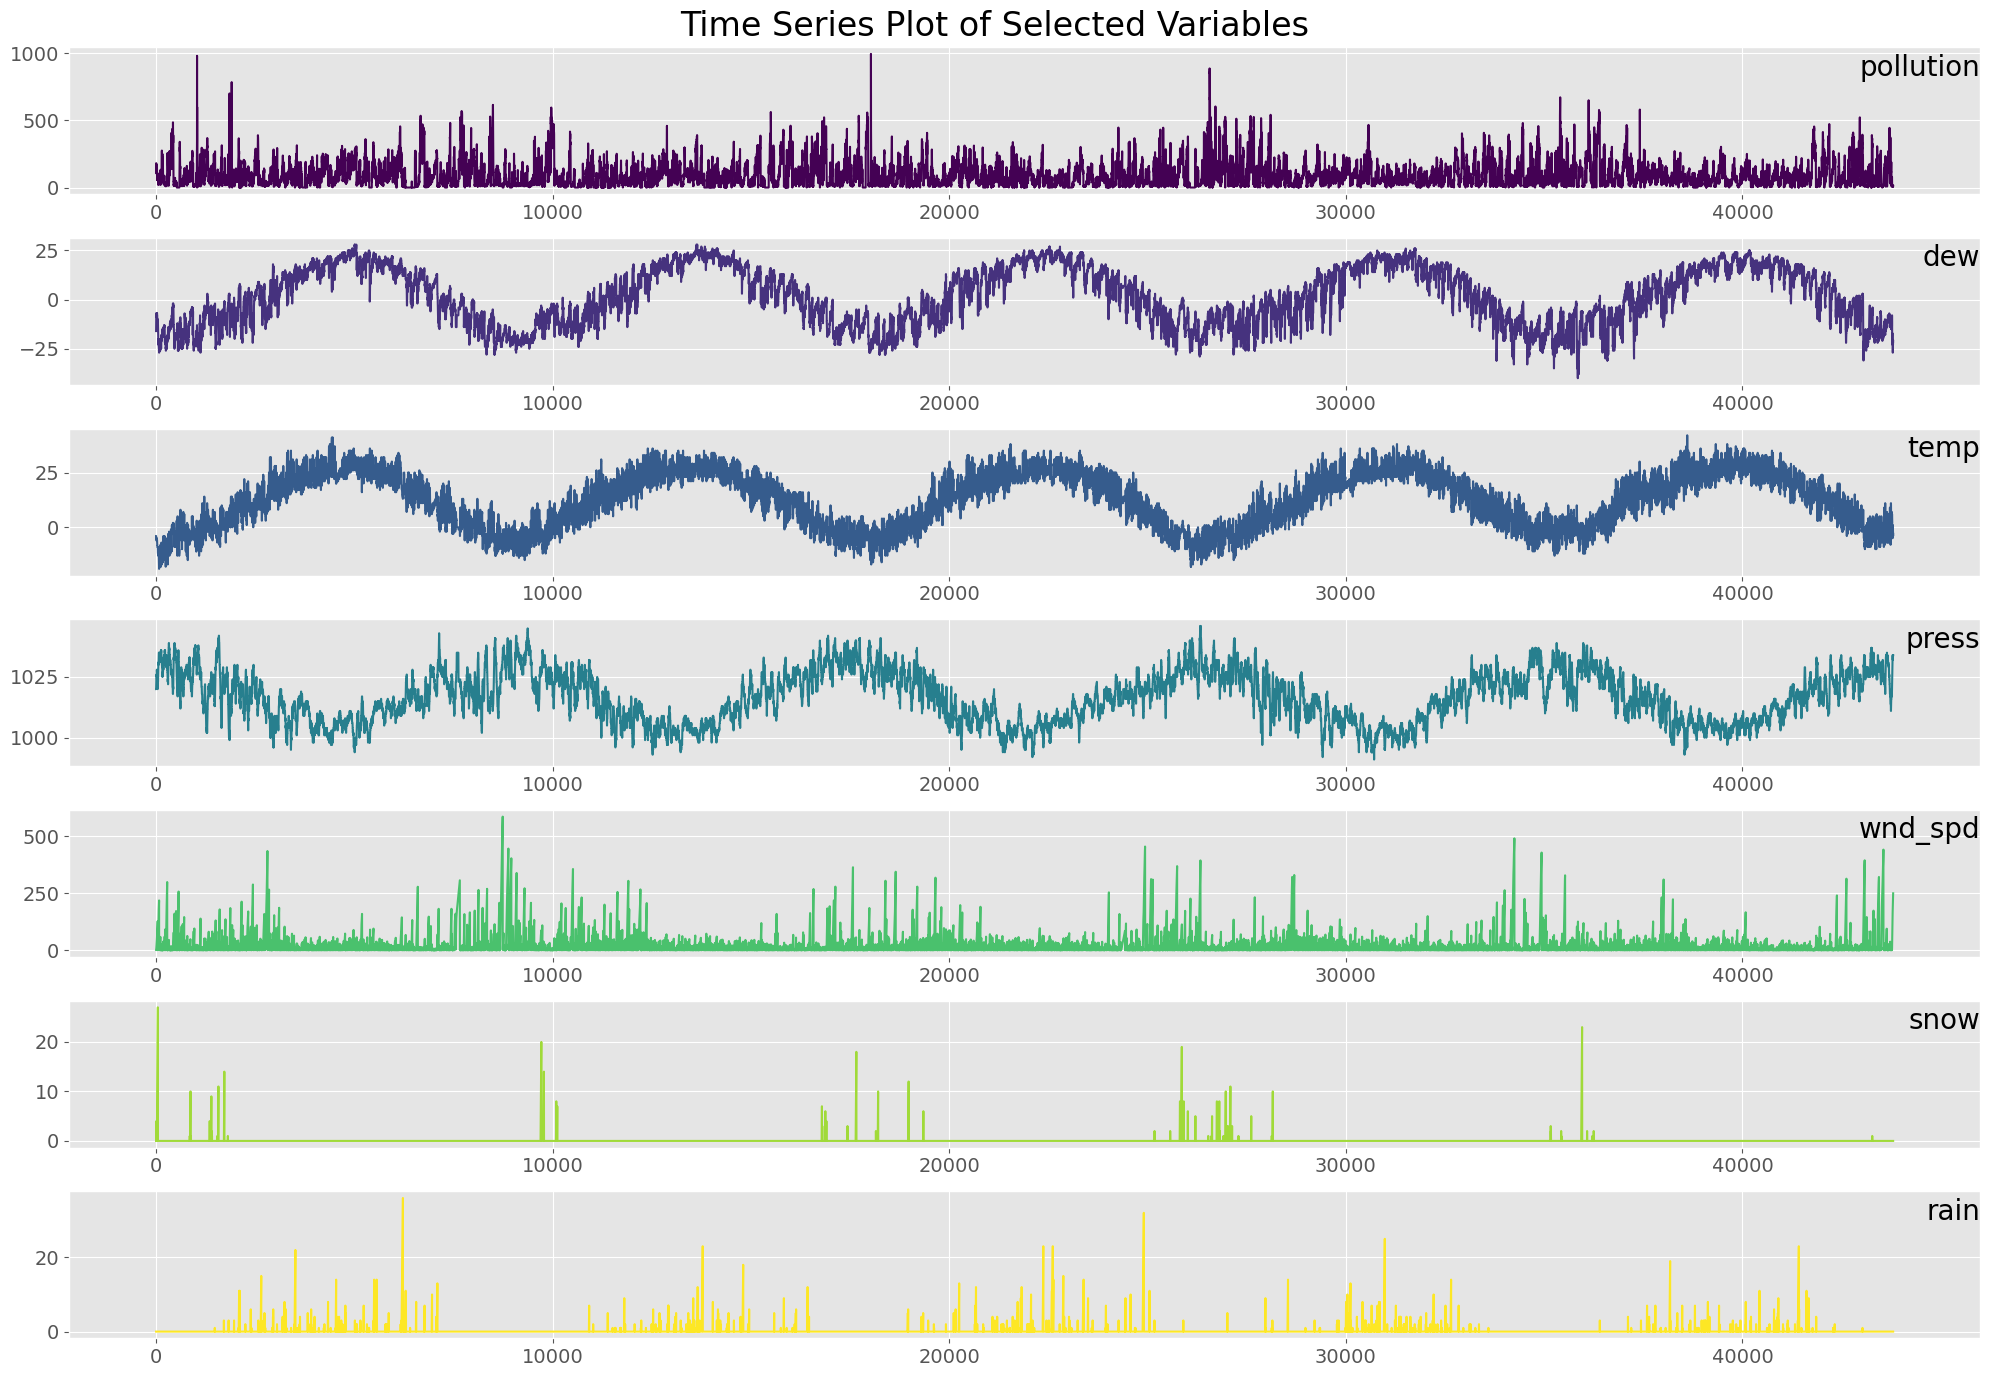

In [205]:
#plot time series figures

def view_timeseries(data:pd.DataFrame)->None:
    groups = [0,1,2,3,5,6,7]
    values = data.values
    fig, axes = plt.subplots(len(groups), 1, figsize=(20,14), facecolor = "white")
    for group, ax in zip(groups, axes):
        ax.plot(values[:, group], color=cm.viridis(group/len(groups)))
        ax.set_title(data.columns[group], y=0.75, loc='right', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True)

    plt.suptitle('Time Series Plot of Selected Variables', fontsize=24)
    plt.tight_layout()
    plt.show()

    return

view_timeseries(df_train)

In [206]:
df_train = df_train.drop(columns = ["snow"])
df_test = df_test.drop(columns = ["snow"])

In [207]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
catogorical_columns = df_train.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[catogorical_columns])
train_encoded = encoder.transform(df_train[catogorical_columns])
test_encoded = encoder.transform(df_test[catogorical_columns])

train_encoded_df = pd.DataFrame(train_encoded, columns = encoder.get_feature_names_out(catogorical_columns))
test_encoded_df = pd.DataFrame(test_encoded, columns = encoder.get_feature_names_out(catogorical_columns))

df_train = pd.concat([df_train, train_encoded_df], axis = 1)
df_test = pd.concat([df_test, test_encoded_df], axis = 1)

df_train = df_train.drop(catogorical_columns, axis = 1)
df_test = df_test.drop(catogorical_columns, axis = 1)

df_test

dew  temp  press  wnd_spd  rain  pollution  wnd_dir_NE  wnd_dir_NW  \
0    -16     4   1027     3.58     0        128         0.0         0.0   
1    -17     5   1027     7.60     0         77         0.0         0.0   
2    -16     4   1027     9.39     0         65         0.0         0.0   
3    -16     1   1028     0.89     0         79         0.0         0.0   
4    -14     0   1028     1.79     0         93         1.0         0.0   
..   ...   ...    ...      ...   ...        ...         ...         ...   
341  -23    -2   1034   231.97     0          8         0.0         1.0   
342  -22    -3   1034   237.78     0         10         0.0         1.0   
343  -22    -3   1034   242.70     0         10         0.0         1.0   
344  -22    -4   1034   246.72     0          8         0.0         1.0   
345  -21    -3   1034   249.85     0         12         0.0         1.0   

     wnd_dir_SE  wnd_dir_cv  
0           1.0         0.0  
1           1.0         0.0  
2           1.0         0.0  
3           0.0         1.0  
4           0.0         0.0  
..          ...         ...  
341         0.0         0.0  
342         0.0         0.0  
343         0.0         0.0  
344         0.0         0.0  
345         0.0         0.0  

[346 rows x 10 columns]

In [208]:
# # df_train_scaled = df_train.copy()
# # df_test_scaled = df_test.copy()

# # Define the mapping dictionary
# mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# # Replace the string values with numerical values
# df_train['wnd_dir'] = df_train['wnd_dir'].map(mapping)
# df_test['wnd_dir'] = df_test['wnd_dir'].map(mapping)

# # df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# # Resetting the index
# # df_train_scaled.set_index('date', inplace=True)
# df_train.head()

In [209]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #defualt is (0,1)

cols = [i for i in range(5)]
columns = df_train.columns[cols].tolist()

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train

pollution       dew      temp     press   wnd_spd  rain  wnd_dir_NE  \
0       0.129779  0.352941  0.245902  0.527273  0.002290     0         0.0   
1       0.148893  0.367647  0.245902  0.527273  0.003811     0         0.0   
2       0.159960  0.426471  0.229508  0.545455  0.005332     0         0.0   
3       0.182093  0.485294  0.229508  0.563636  0.008391     0         0.0   
4       0.138833  0.485294  0.229508  0.563636  0.009912     0         0.0   
...          ...       ...       ...       ...       ...   ...         ...   
43795   0.008048  0.250000  0.278689  0.781818  0.395659     0         0.0   
43796   0.010060  0.264706  0.262295  0.781818  0.405588     0         0.0   
43797   0.010060  0.264706  0.262295  0.781818  0.413996     0         0.0   
43798   0.008048  0.264706  0.245902  0.781818  0.420866     0         0.0   
43799   0.012072  0.279412  0.262295  0.781818  0.426216     0         0.0   

       wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         1.0         0.0  
1             0.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         1.0         0.0  
4             0.0         1.0         0.0  
...           ...         ...         ...  
43795         1.0         0.0         0.0  
43796         1.0         0.0         0.0  
43797         1.0         0.0         0.0  
43798         1.0         0.0         0.0  
43799         1.0         0.0         0.0  

[43800 rows x 10 columns]

In [210]:
train_size = int(len(df_train) *0.9)
num_epochs = 150
steps = train_size*num_epochs
warmup_steps = int(steps*0.2)
train= df_train.iloc[:train_size, :]
val = df_train.iloc[train_size:, :]
train

pollution       dew      temp     press   wnd_spd  rain  wnd_dir_NE  \
0       0.129779  0.352941  0.245902  0.527273  0.002290     0         0.0   
1       0.148893  0.367647  0.245902  0.527273  0.003811     0         0.0   
2       0.159960  0.426471  0.229508  0.545455  0.005332     0         0.0   
3       0.182093  0.485294  0.229508  0.563636  0.008391     0         0.0   
4       0.138833  0.485294  0.229508  0.563636  0.009912     0         0.0   
...          ...       ...       ...       ...       ...   ...         ...   
39415   0.058350  0.882353  0.655738  0.236364  0.003811     0         0.0   
39416   0.057344  0.882353  0.672131  0.236364  0.000752     1         0.0   
39417   0.052314  0.897059  0.672131  0.236364  0.000752     2         0.0   
39418   0.033199  0.897059  0.688525  0.236364  0.000752     0         0.0   
39419   0.050302  0.897059  0.704918  0.236364  0.002290     0         0.0   

       wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         1.0         0.0  
1             0.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         1.0         0.0  
4             0.0         1.0         0.0  
...           ...         ...         ...  
39415         0.0         1.0         0.0  
39416         0.0         0.0         1.0  
39417         0.0         1.0         0.0  
39418         0.0         0.0         1.0  
39419         0.0         1.0         0.0  

[39420 rows x 10 columns]

In [211]:


# TrainSet
X_sequences = []
y_values = []

n_past = 11
n_future = 1
window_size = n_past

for i in range(n_past, len(train) - n_future+1):
    X_seq = train.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = train.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# ValidSet
X_sequences = []
y_values = []

for i in range(n_past, len(val) - n_future+1):
    X_seq = val.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = val.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_valid = np.array(X_sequences)
y_valid = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(n_past, len(df_test) - n_future+1):
    X_seq = df_test.iloc[ i- n_past:i].drop(columns=["pollution"]).values
    Y_val = df_test.iloc[i + n_future - 1:i + n_future]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(39409, 11, 9)
(39409, 1)
--------------------test_data---------------------
(335, 11, 9)
(335, 1)


In [212]:
# # Calculating mean and standard deviation for standardization of features in the training set
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()

# # Standardizing features in the training and validation sets based on the training set statistics
# X_train = (X_train - X_train_mean) / X_train_std
# X_valid = (X_valid - X_train_mean) / X_train_std

# # Calculating mean and standard deviation for standardization of target values in the training set
# y_train_mean = y_train.mean()
# y_train_std = y_train.std()

# # Standardizing target values in the training and validation sets based on the training set statistics
# y_train = (y_train - y_train_mean) / y_train_std
# y_valid = (y_valid - y_train_mean) / y_train_std
# X_test = (X_test - X_train_mean) / X_train_std
# y_test = (y_test - y_train_mean) / y_train_std

In [213]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

In [216]:
class ResLSTMCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        #self.dropout_layer = nn.Dropout(dropout)
        self.dropout = dropout

    @jit.script_method
    def forward(self, input, hidden):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.mm(input, self.weight_ii.t()) + self.bias_ii +
                     torch.mm(hx, self.weight_ih.t()) + self.bias_ih +
                     torch.mm(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)
        
        cellgate = torch.mm(hx, self.weight_hh.t()) + self.bias_hh
        
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
          hy = outgate * (ry + input)
        else:
          hy = outgate * (ry + torch.mm(input, self.weight_ir.t()))
        return hy, (hy, cy)

In [217]:
class ResLSTMLayer(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.cell = LSTMCell(input_size, hidden_size, dropout=0.)
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    @jit.script_method
    def forward(self, input, hidden):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, hidden = self.cell(inputs[i], hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        # print("outputs.size()", outputs.size())
        return outputs, hidden

In [218]:
class ResLSTM(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dropout=0, batch_first=False):
        super().__init__()
        self.batch_first = batch_first
        layers = []
        for i in range(n_layers):
            if i == 0:
                c = ResLSTMLayer(n_input, n_hidden, dropout=dropout)
            else:
                c = ResLSTMLayer(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
            
        outputs = []
        for i, cell in enumerate(self.cells):

            # first layer: ResLSTM inputs size before torch.Size([28, 32, 1])
            # first layer: ResLSTM inputs size after torch.Size([28, 32, 64])
            # outputs from each layer is used as inputs to the next layer
            inputs, _ = self.res_layer(cell, inputs)

            # inputs[-1:] size torch.Size([1, 32, 64])
            # outputs have the length of num_layers
            outputs.append(inputs[-1:].squeeze())
            
        outputs = torch.stack(outputs)

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        # inputs is the output from the last layer
        # outputs is the output at the last time step from all layers
        return inputs, outputs

    def res_layer(self, cell, inputs, hidden=None):

        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        if hidden is None:
            outputs, hidden = self._apply_cell(inputs, cell, batch_size, hidden_size)
        else:
            outputs, hidden = self._apply_cell(inputs, cell, batch_size, hidden_size,
                                                       hidden=hidden)
        return outputs, hidden

    def _apply_cell(self, inputs, cell, batch_size, hidden_size, hidden=None):
        if hidden is None:
            c, m = self.init_hidden(batch_size, hidden_size)
            hidden = (c.unsqueeze(0), m.unsqueeze(0))
        
        outputs, hidden = cell(inputs, hidden) 
        
        return outputs, hidden


    def init_hidden(self, batch_size, hidden_dim):
        
        hidden = autograd.Variable(torch.zeros(batch_size, hidden_dim))
        if use_cuda:
            hidden = hidden.cuda()
        memory = autograd.Variable(torch.zeros(batch_size, hidden_dim))
        if use_cuda:
            memory = memory.cuda()
        return hidden, memory

In [220]:
class seq2vec(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = ResLSTM(n_input=input_size, n_hidden=hidden_size, n_layers=num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1).cuda()

    def forward(self, x):
        
        out, hidden = self.lstm(x)
        hidden = hidden[-1:].squeeze()
        out = out[:, -1, :]
        pred = self.fc(out)
        return pred#.squeeze()

In [222]:
from timm.scheduler import CosineLRScheduler


model = seq2vec(input_size=9,hidden_size=16,num_layers=5).to(device)
# model = MultiResidualBiGRU(input_size=9,hidden_size=16,out_size=1,n_layers=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 0)


steps = train_size*num_epochs
scheduler = CosineLRScheduler(optimizer,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, last_epoch=-1)
criterion = nn.MSELoss().to(device)

model

seq2vec(
  (lstm): ResLSTM(
    (cells): Sequential(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
      (1): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
      (2): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
      (3): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
      (4): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [223]:
batch_size = 32

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

val_set = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=1,
                          shuffle=True,
                          drop_last=True,
                          )

In [226]:
import copy
model_path = '../ML2024/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

In [227]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "16x5_loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

#     plt.figure()
#     plt.plot(epochs, history["lr"])
#     plt.title("Learning Rate evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("LR")
#     plt.savefig(os.path.join(model_path, "lr_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

train: 100%|██████████| 1231/1231 [01:00<00:00, 20.50batch/s]


Epoch: 0, train_avg_loss: 0.14871359589281943


Eval: 100%|██████████| 136/136 [00:03<00:00, 37.04batch/s]


Epoch: 0, val_avg_loss: 0.11930389773538884


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.18batch/s]


Epoch: 1, train_avg_loss: 0.07862575528015943


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.02batch/s]


Epoch: 1, val_avg_loss: 0.05240809596965418


train: 100%|██████████| 1231/1231 [00:56<00:00, 21.85batch/s]


Epoch: 2, train_avg_loss: 0.03671597266171784


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.30batch/s]


Epoch: 2, val_avg_loss: 0.025923060992842212


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.49batch/s]


Epoch: 3, train_avg_loss: 0.020570998475376204


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.10batch/s]


Epoch: 3, val_avg_loss: 0.014751115776187576


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 4, train_avg_loss: 0.01357169208006372


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.59batch/s]


Epoch: 4, val_avg_loss: 0.01100832860410104


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.95batch/s]


Epoch: 5, train_avg_loss: 0.01053670087165731


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.59batch/s]


Epoch: 5, val_avg_loss: 0.009207236717509873


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 6, train_avg_loss: 0.008998260588765713


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.17batch/s]


Epoch: 6, val_avg_loss: 0.008096637723022415


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.82batch/s]


Epoch: 7, train_avg_loss: 0.008436077313155698


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.15batch/s]


Epoch: 7, val_avg_loss: 0.007746273220297606


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.84batch/s]


Epoch: 8, train_avg_loss: 0.008357471763742687


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.88batch/s]


Epoch: 8, val_avg_loss: 0.007683479273349375


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.79batch/s]


Epoch: 9, train_avg_loss: 0.008028605832755385


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.90batch/s]


Epoch: 9, val_avg_loss: 0.007624302222051055


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.87batch/s]


Epoch: 10, train_avg_loss: 0.007879603547093274


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.19batch/s]


Epoch: 10, val_avg_loss: 0.007514223422142951


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 11, train_avg_loss: 0.007804583092723238


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.45batch/s]


Epoch: 11, val_avg_loss: 0.0073967849089325785


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.81batch/s]


Epoch: 12, train_avg_loss: 0.007700193318168411


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.61batch/s]


Epoch: 12, val_avg_loss: 0.007251176351393738


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.79batch/s]


Epoch: 13, train_avg_loss: 0.007614937448264331


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.07batch/s]


Epoch: 13, val_avg_loss: 0.0072843513369341105


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.68batch/s]


Epoch: 14, train_avg_loss: 0.007520972542460194


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.80batch/s]


Epoch: 14, val_avg_loss: 0.0071889040940304235


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 15, train_avg_loss: 0.007385907027697165


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.77batch/s]


Epoch: 15, val_avg_loss: 0.0071077677729430005


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.60batch/s]


Epoch: 16, train_avg_loss: 0.007304940906929792


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.65batch/s]


Epoch: 16, val_avg_loss: 0.006978030366179369


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.75batch/s]


Epoch: 17, train_avg_loss: 0.0071811805733431894


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.51batch/s]


Epoch: 17, val_avg_loss: 0.00692874940303976


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 18, train_avg_loss: 0.00710959557408299


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.34batch/s]


Epoch: 18, val_avg_loss: 0.006958823835970286


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.88batch/s]


Epoch: 19, train_avg_loss: 0.006966695495503618


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.09batch/s]


Epoch: 19, val_avg_loss: 0.006671082437284948


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.82batch/s]


Epoch: 20, train_avg_loss: 0.006887593144130274


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.52batch/s]


Epoch: 20, val_avg_loss: 0.006670592169564984


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.97batch/s]


Epoch: 21, train_avg_loss: 0.006822820815558838


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.93batch/s]


Epoch: 21, val_avg_loss: 0.006592868751955821


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.78batch/s]


Epoch: 22, train_avg_loss: 0.0067130062592183305


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.07batch/s]


Epoch: 22, val_avg_loss: 0.006552941660629585


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.70batch/s]


Epoch: 23, train_avg_loss: 0.006632683965870028


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.28batch/s]


Epoch: 23, val_avg_loss: 0.006275229752645828


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.72batch/s]


Epoch: 24, train_avg_loss: 0.00651641776355908


Eval: 100%|██████████| 136/136 [00:02<00:00, 51.45batch/s]


Epoch: 24, val_avg_loss: 0.0064207618946538255


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.26batch/s]


Epoch: 25, train_avg_loss: 0.006439430919830679


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.07batch/s]


Epoch: 25, val_avg_loss: 0.006200428124215892


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.87batch/s]


Epoch: 26, train_avg_loss: 0.006411403701107292


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.81batch/s]


Epoch: 26, val_avg_loss: 0.006225550441954778


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.69batch/s]


Epoch: 27, train_avg_loss: 0.006359824323009133


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.51batch/s]


Epoch: 27, val_avg_loss: 0.0060723000805249765


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.66batch/s]


Epoch: 28, train_avg_loss: 0.006316171556553833


Eval: 100%|██████████| 136/136 [00:02<00:00, 50.45batch/s]


Epoch: 28, val_avg_loss: 0.006098893832292079


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.71batch/s]


Epoch: 29, train_avg_loss: 0.006276536663025043


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.06batch/s]


Epoch: 29, val_avg_loss: 0.006278646644204855


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.72batch/s]


Epoch: 30, train_avg_loss: 0.006181493530520499


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.62batch/s]


Epoch: 30, val_avg_loss: 0.006023588823154569


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 31, train_avg_loss: 0.006098318480372816


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.81batch/s]


Epoch: 31, val_avg_loss: 0.0060883078960400515


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.77batch/s]


Epoch: 32, train_avg_loss: 0.00603272487896636


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.07batch/s]


Epoch: 32, val_avg_loss: 0.005901991247596657


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.86batch/s]


Epoch: 33, train_avg_loss: 0.0059402325577583015


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.39batch/s]


Epoch: 33, val_avg_loss: 0.006105933364083552


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 34, train_avg_loss: 0.005889086795525942


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.22batch/s]


Epoch: 34, val_avg_loss: 0.005896762636599734


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 35, train_avg_loss: 0.005831448859281711


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.58batch/s]


Epoch: 35, val_avg_loss: 0.005722138219211689


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 36, train_avg_loss: 0.005775787995180234


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.25batch/s]


Epoch: 36, val_avg_loss: 0.005812072031617658


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 37, train_avg_loss: 0.005698892902234867


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.54batch/s]


Epoch: 37, val_avg_loss: 0.005746106350082247


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.90batch/s]


Epoch: 38, train_avg_loss: 0.005634632370787257


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.57batch/s]


Epoch: 38, val_avg_loss: 0.005822153027539197


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.87batch/s]


Epoch: 39, train_avg_loss: 0.005594406229656441


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.96batch/s]


Epoch: 39, val_avg_loss: 0.0055244131166118145


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.86batch/s]


Epoch: 40, train_avg_loss: 0.005566535318976951


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.49batch/s]


Epoch: 40, val_avg_loss: 0.005583542082390255


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.77batch/s]


Epoch: 41, train_avg_loss: 0.005508134671060216


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.37batch/s]


Epoch: 41, val_avg_loss: 0.005981516452533577


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 42, train_avg_loss: 0.0054733953162555676


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.77batch/s]


Epoch: 42, val_avg_loss: 0.00554993817315656


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.88batch/s]


Epoch: 43, train_avg_loss: 0.005391432775565061


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.11batch/s]


Epoch: 43, val_avg_loss: 0.005514885365675368


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.84batch/s]


Epoch: 44, train_avg_loss: 0.005346630323355962


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.24batch/s]


Epoch: 44, val_avg_loss: 0.005589047499918653


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 45, train_avg_loss: 0.005274590681930043


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.53batch/s]


Epoch: 45, val_avg_loss: 0.0057703195266453


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.74batch/s]


Epoch: 46, train_avg_loss: 0.005233765997190806


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.43batch/s]


Epoch: 46, val_avg_loss: 0.005561981197816375


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 47, train_avg_loss: 0.005182436810561269


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.90batch/s]


Epoch: 47, val_avg_loss: 0.005473968471051194


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.67batch/s]


Epoch: 48, train_avg_loss: 0.005161852453749061


Eval: 100%|██████████| 136/136 [00:02<00:00, 50.57batch/s]


Epoch: 48, val_avg_loss: 0.005574506943744114


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 49, train_avg_loss: 0.005073813615808646


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.49batch/s]


Epoch: 49, val_avg_loss: 0.005604922119185657


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.89batch/s]


Epoch: 50, train_avg_loss: 0.005073536225238241


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.73batch/s]


Epoch: 50, val_avg_loss: 0.0054200003505684435


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.85batch/s]


Epoch: 51, train_avg_loss: 0.005065072728165862


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.71batch/s]


Epoch: 51, val_avg_loss: 0.005432715772151235


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 52, train_avg_loss: 0.004962009308268834


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.89batch/s]


Epoch: 52, val_avg_loss: 0.0055167060268371745


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.80batch/s]


Epoch: 53, train_avg_loss: 0.004955690054228237


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.05batch/s]


Epoch: 53, val_avg_loss: 0.005501971082755036


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.79batch/s]


Epoch: 54, train_avg_loss: 0.0048737661827168


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.77batch/s]


Epoch: 54, val_avg_loss: 0.0055326264675172486


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 55, train_avg_loss: 0.004889284476284528


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.28batch/s]


Epoch: 55, val_avg_loss: 0.005580173177055686


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 56, train_avg_loss: 0.0048382669320529755


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.21batch/s]


Epoch: 56, val_avg_loss: 0.005564660320113248


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.68batch/s]


Epoch: 57, train_avg_loss: 0.004767022745882007


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.67batch/s]


Epoch: 57, val_avg_loss: 0.005603695290012504


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.67batch/s]


Epoch: 58, train_avg_loss: 0.0046953108262120895


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.97batch/s]


Epoch: 58, val_avg_loss: 0.005328594247283249


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.52batch/s]


Epoch: 59, train_avg_loss: 0.004682910551164212


Eval: 100%|██████████| 136/136 [00:03<00:00, 45.15batch/s]


Epoch: 59, val_avg_loss: 0.0056127262103152185


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.79batch/s]


Epoch: 60, train_avg_loss: 0.004625832465943327


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.95batch/s]


Epoch: 60, val_avg_loss: 0.005470894835204543


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.66batch/s]


Epoch: 61, train_avg_loss: 0.004599890481301596


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.29batch/s]


Epoch: 61, val_avg_loss: 0.005648295915521243


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.60batch/s]


Epoch: 62, train_avg_loss: 0.004519405164702922


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.92batch/s]


Epoch: 62, val_avg_loss: 0.005432268708211589


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.76batch/s]


Epoch: 63, train_avg_loss: 0.004471854827836592


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.44batch/s]


Epoch: 63, val_avg_loss: 0.005545164815403576


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.83batch/s]


Epoch: 64, train_avg_loss: 0.004442919264615617


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.33batch/s]


Epoch: 64, val_avg_loss: 0.005544065460151828


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.42batch/s]


Epoch: 65, train_avg_loss: 0.004403054385383974


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.30batch/s]


Epoch: 65, val_avg_loss: 0.00561766087604851


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.37batch/s]


Epoch: 66, train_avg_loss: 0.004340173182388651


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.99batch/s]


Epoch: 66, val_avg_loss: 0.005423982826280682


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.46batch/s]


Epoch: 67, train_avg_loss: 0.004290928714483095


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.61batch/s]


Epoch: 67, val_avg_loss: 0.005537229067104978


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.54batch/s]


Epoch: 68, train_avg_loss: 0.004265503584506379


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.20batch/s]


Epoch: 68, val_avg_loss: 0.005811525889679187


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.38batch/s]


Epoch: 69, train_avg_loss: 0.004238362904300627


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.54batch/s]


Epoch: 69, val_avg_loss: 0.005607319241629311


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.56batch/s]


Epoch: 70, train_avg_loss: 0.004207261981197446


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.12batch/s]


Epoch: 70, val_avg_loss: 0.005618255576016107


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.46batch/s]


Epoch: 71, train_avg_loss: 0.0041714420415019235


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.35batch/s]


Epoch: 71, val_avg_loss: 0.005512632050393971


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.27batch/s]


Epoch: 72, train_avg_loss: 0.004128857234029128


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.03batch/s]


Epoch: 72, val_avg_loss: 0.005669719418031438


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.47batch/s]


Epoch: 73, train_avg_loss: 0.0040971315976543994


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.30batch/s]


Epoch: 73, val_avg_loss: 0.005586803387439645


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.43batch/s]


Epoch: 74, train_avg_loss: 0.004028847487889242


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.26batch/s]


Epoch: 74, val_avg_loss: 0.005550712025176515


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.38batch/s]


Epoch: 75, train_avg_loss: 0.004002469037239577


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.99batch/s]


Epoch: 75, val_avg_loss: 0.005767025935175993


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.23batch/s]


Epoch: 76, train_avg_loss: 0.0039519300299150385


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.67batch/s]


Epoch: 76, val_avg_loss: 0.005627189001910772


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.39batch/s]


Epoch: 77, train_avg_loss: 0.003925776582609962


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.06batch/s]


Epoch: 77, val_avg_loss: 0.005430812239544192


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.46batch/s]


Epoch: 78, train_avg_loss: 0.003891828096854545


Eval: 100%|██████████| 136/136 [00:03<00:00, 45.06batch/s]


Epoch: 78, val_avg_loss: 0.0057180479035356686


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.20batch/s]


Epoch: 79, train_avg_loss: 0.00385865982072269


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.41batch/s]


Epoch: 79, val_avg_loss: 0.005802540267776588


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.25batch/s]


Epoch: 80, train_avg_loss: 0.003811133848325441


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.90batch/s]


Epoch: 80, val_avg_loss: 0.005851894808823571


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.43batch/s]


Epoch: 81, train_avg_loss: 0.0037861295851290976


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.15batch/s]


Epoch: 81, val_avg_loss: 0.00596619384818683


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.54batch/s]


Epoch: 82, train_avg_loss: 0.0037570158821613104


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.62batch/s]


Epoch: 82, val_avg_loss: 0.005915994742227828


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.41batch/s]


Epoch: 83, train_avg_loss: 0.0036791385609447006


Eval: 100%|██████████| 136/136 [00:03<00:00, 42.95batch/s]


Epoch: 83, val_avg_loss: 0.005927408126059591


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.51batch/s]


Epoch: 84, train_avg_loss: 0.0037135068166609113


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.83batch/s]


Epoch: 84, val_avg_loss: 0.006106480896157925


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.43batch/s]


Epoch: 85, train_avg_loss: 0.0036212219613635265


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.04batch/s]


Epoch: 85, val_avg_loss: 0.0057872385343002595


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.40batch/s]


Epoch: 86, train_avg_loss: 0.003609962507577009


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.24batch/s]


Epoch: 86, val_avg_loss: 0.005943016333998565


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.23batch/s]


Epoch: 87, train_avg_loss: 0.003562670451152773


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.10batch/s]


Epoch: 87, val_avg_loss: 0.005828338571625543


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.58batch/s]


Epoch: 88, train_avg_loss: 0.003538813477408165


Eval: 100%|██████████| 136/136 [00:03<00:00, 45.08batch/s]


Epoch: 88, val_avg_loss: 0.006066388547290391


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.41batch/s]


Epoch: 89, train_avg_loss: 0.003510754360839313


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.62batch/s]


Epoch: 89, val_avg_loss: 0.005860083522480529


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.52batch/s]


Epoch: 90, train_avg_loss: 0.003489254282902439


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.62batch/s]


Epoch: 90, val_avg_loss: 0.00601876513375079


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.24batch/s]


Epoch: 91, train_avg_loss: 0.003471168952475428


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.27batch/s]


Epoch: 91, val_avg_loss: 0.005756605229929418


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.31batch/s]


Epoch: 92, train_avg_loss: 0.0034589093996727858


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.53batch/s]


Epoch: 92, val_avg_loss: 0.005919741891214953


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.44batch/s]


Epoch: 93, train_avg_loss: 0.0033809920124350996


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.73batch/s]


Epoch: 93, val_avg_loss: 0.006009238458800074


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.16batch/s]


Epoch: 94, train_avg_loss: 0.0033859633623110168


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.49batch/s]


Epoch: 94, val_avg_loss: 0.005924856423756436


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.29batch/s]


Epoch: 95, train_avg_loss: 0.0033542597079577693


Eval: 100%|██████████| 136/136 [00:03<00:00, 42.68batch/s]


Epoch: 95, val_avg_loss: 0.005974059529869598


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.54batch/s]


Epoch: 96, train_avg_loss: 0.003324659795358105


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.58batch/s]


Epoch: 96, val_avg_loss: 0.00606322379248655


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.52batch/s]


Epoch: 97, train_avg_loss: 0.0033091272140556537


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.54batch/s]


Epoch: 97, val_avg_loss: 0.006299564731307328


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.43batch/s]


Epoch: 98, train_avg_loss: 0.00329584809955267


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.97batch/s]


Epoch: 98, val_avg_loss: 0.00606015528747401


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.39batch/s]


Epoch: 99, train_avg_loss: 0.00325759756539598


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.04batch/s]


Epoch: 99, val_avg_loss: 0.0062764791518395


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.31batch/s]


Epoch: 100, train_avg_loss: 0.003239852961385055


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.83batch/s]


Epoch: 100, val_avg_loss: 0.006191438057131189


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.49batch/s]


Epoch: 101, train_avg_loss: 0.003212479670646666


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.22batch/s]


Epoch: 101, val_avg_loss: 0.006252862143275493


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.49batch/s]


Epoch: 102, train_avg_loss: 0.003200865108565186


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.46batch/s]


Epoch: 102, val_avg_loss: 0.00626669408281005


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.50batch/s]


Epoch: 103, train_avg_loss: 0.0031657247162166042


Eval: 100%|██████████| 136/136 [00:03<00:00, 42.49batch/s]


Epoch: 103, val_avg_loss: 0.0062009507416994035


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.59batch/s]


Epoch: 104, train_avg_loss: 0.003160436583511156


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.87batch/s]


Epoch: 104, val_avg_loss: 0.006087751911870916


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.55batch/s]


Epoch: 105, train_avg_loss: 0.003133641049626361


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.82batch/s]


Epoch: 105, val_avg_loss: 0.006120721971349078


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.40batch/s]


Epoch: 106, train_avg_loss: 0.0031158203351505064


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.44batch/s]


Epoch: 106, val_avg_loss: 0.0061217061969835096


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.27batch/s]


Epoch: 107, train_avg_loss: 0.0030935359062875863


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.16batch/s]


Epoch: 107, val_avg_loss: 0.0064044299968586795


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.36batch/s]


Epoch: 108, train_avg_loss: 0.0030769126030717082


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.39batch/s]


Epoch: 108, val_avg_loss: 0.006239604527603232


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.45batch/s]


Epoch: 109, train_avg_loss: 0.0030512966642214498


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.89batch/s]


Epoch: 109, val_avg_loss: 0.006246103593559169


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.14batch/s]


Epoch: 110, train_avg_loss: 0.0030417117410964332


Eval: 100%|██████████| 136/136 [00:02<00:00, 49.59batch/s]


Epoch: 110, val_avg_loss: 0.0063035833128892325


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.19batch/s]


Epoch: 111, train_avg_loss: 0.0030250878567023584


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.23batch/s]


Epoch: 111, val_avg_loss: 0.006399359168854597


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.33batch/s]


Epoch: 112, train_avg_loss: 0.0030125794166420638


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.05batch/s]


Epoch: 112, val_avg_loss: 0.0063058485701570615


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.38batch/s]


Epoch: 113, train_avg_loss: 0.0029995320877873595


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.80batch/s]


Epoch: 113, val_avg_loss: 0.0063843397125738725


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.31batch/s]


Epoch: 114, train_avg_loss: 0.002990571538617745


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.26batch/s]


Epoch: 114, val_avg_loss: 0.006253797963247909


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.47batch/s]


Epoch: 115, train_avg_loss: 0.0029675645188592635


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.33batch/s]


Epoch: 115, val_avg_loss: 0.006478176822009332


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.45batch/s]


Epoch: 116, train_avg_loss: 0.002951586275967859


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.15batch/s]


Epoch: 116, val_avg_loss: 0.00660928082994788


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.35batch/s]


Epoch: 117, train_avg_loss: 0.0029429992163254237


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.61batch/s]


Epoch: 117, val_avg_loss: 0.0064079868025146425


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.54batch/s]


Epoch: 118, train_avg_loss: 0.002928423773853682


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.56batch/s]


Epoch: 118, val_avg_loss: 0.006545799123106168


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.40batch/s]


Epoch: 119, train_avg_loss: 0.0029197238213749593


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.62batch/s]


Epoch: 119, val_avg_loss: 0.006630742814569899


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.38batch/s]


Epoch: 120, train_avg_loss: 0.002910194046580506


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.61batch/s]


Epoch: 120, val_avg_loss: 0.006532699000672437


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.33batch/s]


Epoch: 121, train_avg_loss: 0.002896472289012087


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.30batch/s]


Epoch: 121, val_avg_loss: 0.00648269391454318


train: 100%|██████████| 1231/1231 [00:53<00:00, 23.14batch/s]


Epoch: 122, train_avg_loss: 0.002887343556182701


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.92batch/s]


Epoch: 122, val_avg_loss: 0.006535601891193758


train: 100%|██████████| 1231/1231 [00:53<00:00, 23.16batch/s]


Epoch: 123, train_avg_loss: 0.0028803122373052686


Eval: 100%|██████████| 136/136 [00:03<00:00, 45.32batch/s]


Epoch: 123, val_avg_loss: 0.006500084935824442


train: 100%|██████████| 1231/1231 [00:53<00:00, 23.11batch/s]


Epoch: 124, train_avg_loss: 0.00287185295293551


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.14batch/s]


Epoch: 124, val_avg_loss: 0.006522237874485333


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.93batch/s]


Epoch: 125, train_avg_loss: 0.002857894141050729


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.71batch/s]


Epoch: 125, val_avg_loss: 0.006502677742152146


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.52batch/s]


Epoch: 126, train_avg_loss: 0.0028490354806323974


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.96batch/s]


Epoch: 126, val_avg_loss: 0.006398798629080001


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.78batch/s]


Epoch: 127, train_avg_loss: 0.002844066698087877


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.64batch/s]


Epoch: 127, val_avg_loss: 0.006528623977347332


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.68batch/s]


Epoch: 128, train_avg_loss: 0.0028367071400871645


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.40batch/s]


Epoch: 128, val_avg_loss: 0.006553072004702271


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.59batch/s]


Epoch: 129, train_avg_loss: 0.002830285253882738


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.87batch/s]


Epoch: 129, val_avg_loss: 0.006583678125239471


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.32batch/s]


Epoch: 130, train_avg_loss: 0.0028234158365406203


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.35batch/s]


Epoch: 130, val_avg_loss: 0.0065831818278906315


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.11batch/s]


Epoch: 131, train_avg_loss: 0.0028176511174285743


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.57batch/s]


Epoch: 131, val_avg_loss: 0.006639711451819441


train: 100%|██████████| 1231/1231 [00:56<00:00, 21.83batch/s]


Epoch: 132, train_avg_loss: 0.0028122052343964735


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.10batch/s]


Epoch: 132, val_avg_loss: 0.0065859850240967185


train: 100%|██████████| 1231/1231 [00:56<00:00, 21.92batch/s]


Epoch: 133, train_avg_loss: 0.002808615703371775


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.50batch/s]


Epoch: 133, val_avg_loss: 0.006621655464507914


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.09batch/s]


Epoch: 134, train_avg_loss: 0.002799760785880994


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.63batch/s]


Epoch: 134, val_avg_loss: 0.00660374055544654


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.69batch/s]


Epoch: 135, train_avg_loss: 0.0027982488654839112


Eval: 100%|██████████| 136/136 [00:02<00:00, 46.09batch/s]


Epoch: 135, val_avg_loss: 0.006603800784967675


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.03batch/s]


Epoch: 136, train_avg_loss: 0.0027946128467287775


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.69batch/s]


Epoch: 136, val_avg_loss: 0.006650277534979121


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.27batch/s]


Epoch: 137, train_avg_loss: 0.0027905502104087695


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.43batch/s]


Epoch: 137, val_avg_loss: 0.00664995977507822


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.68batch/s]


Epoch: 138, train_avg_loss: 0.0027866983108822433


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.91batch/s]


Epoch: 138, val_avg_loss: 0.006654054101090878


train: 100%|██████████| 1231/1231 [00:53<00:00, 22.87batch/s]


Epoch: 139, train_avg_loss: 0.002783310759022369


Eval: 100%|██████████| 136/136 [00:02<00:00, 45.95batch/s]


Epoch: 139, val_avg_loss: 0.006661624637405004


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.66batch/s]


Epoch: 140, train_avg_loss: 0.002780711974399762


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.93batch/s]


Epoch: 140, val_avg_loss: 0.0066206075905082635


train: 100%|██████████| 1231/1231 [00:56<00:00, 21.97batch/s]


Epoch: 141, train_avg_loss: 0.002779646481559056


Eval: 100%|██████████| 136/136 [00:02<00:00, 48.22batch/s]


Epoch: 141, val_avg_loss: 0.006632515458691427


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.33batch/s]


Epoch: 142, train_avg_loss: 0.0027776386615385963


Eval: 100%|██████████| 136/136 [00:02<00:00, 47.37batch/s]


Epoch: 142, val_avg_loss: 0.006629433710580035


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.36batch/s]


Epoch: 143, train_avg_loss: 0.0027753624100571726


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.44batch/s]


Epoch: 143, val_avg_loss: 0.0066325409125591464


train: 100%|██████████| 1231/1231 [00:54<00:00, 22.55batch/s]


Epoch: 144, train_avg_loss: 0.0027729105879098727


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.98batch/s]


Epoch: 144, val_avg_loss: 0.006652833804871668


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.30batch/s]


Epoch: 145, train_avg_loss: 0.0027710930752124605


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.35batch/s]


Epoch: 145, val_avg_loss: 0.006628980706034995


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.07batch/s]


Epoch: 146, train_avg_loss: 0.0027715699383773357


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.97batch/s]


Epoch: 146, val_avg_loss: 0.006637784913490417


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.10batch/s]


Epoch: 147, train_avg_loss: 0.00277038654991502


Eval: 100%|██████████| 136/136 [00:03<00:00, 44.59batch/s]


Epoch: 147, val_avg_loss: 0.006639875656486873


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.18batch/s]


Epoch: 148, train_avg_loss: 0.0027688277403390524


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.82batch/s]


Epoch: 148, val_avg_loss: 0.006619783907594597


train: 100%|██████████| 1231/1231 [00:55<00:00, 22.21batch/s]


Epoch: 149, train_avg_loss: 0.0027696646888612504


Eval: 100%|██████████| 136/136 [00:03<00:00, 43.71batch/s]


Epoch: 149, val_avg_loss: 0.0066316412797759235


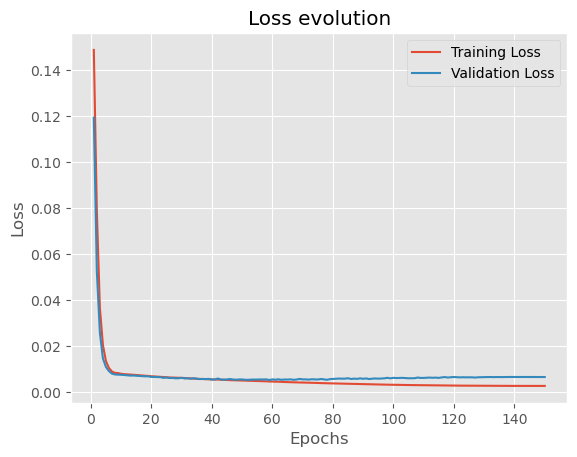

In [228]:
train_losses = []  # To store train losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    model.to(device)
    model.train()
    train_loss = 0.0
    i = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="train", unit="batch")):
        # h = None
        # c = None
        inputs = inputs.reshape(-1, window_size, 9).to(device)
        targets = targets.reshape(-1, 1).to(device)
        # inputs = inputs.to(device)
        # targets = targets.to(device)
        outputs = model(inputs)
        # h = [hi.detach() for hi in h[0]]
        # c = [hi.detach() for hi in h[1]]
        optimizer.zero_grad()
        scheduler.step(i+train_size*epoch)
        loss = criterion(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print(scheduler.get_last_lr())
    train_loss = (train_loss)/len(train_loader)
    print(f'Epoch: {epoch}, train_avg_loss: {train_loss}')
    history["train_loss"].append(train_loss)
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader, desc="Eval", unit="batch")):
            # h = None
            inputs = inputs.reshape(-1, window_size, 9).to(device)
            targets = targets.reshape(-1, 1).to(device)
            # inputs = inputs.to(device)
            # targets = targets.to(device)
            outputs = model(inputs)
            # outputs,h = model(inputs, h)
            # h = [hi.detach() for hi in h]
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
        valid_loss = (valid_loss)/len(val_loader)
        print(f'Epoch: {epoch}, val_avg_loss: {valid_loss}')
    
        history["valid_loss"].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"rltmmodel_16x5_best.pth"),
            )

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "16x5_history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

In [229]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

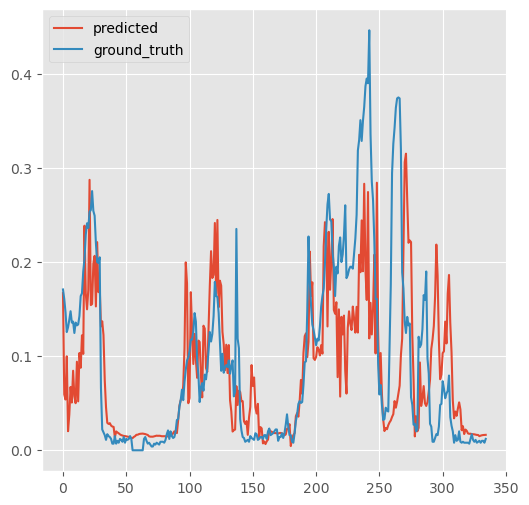

In [230]:
with torch.no_grad():
    # h = None
    predicted = model(X_test.to(device))
    # h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [231]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [232]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.07908106
0.050052438
0.3662694660414666
